# COVID-19 Cases by States for a Country
[Work in progress]

This notebooks uses data from the [Corona Data Scraper](https://coronadatascraper.com/)

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
from py2neo import Graph
import ipywidgets as widgets

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

#### Setup dropdown menus

In [4]:
query = """
// get list of countries and territories
MATCH (c:Country)
RETURN c.name as country
ORDER BY country
"""
countries = graph.run(query).to_data_frame()['country'].values

In [5]:
state_widget = widgets.Dropdown(options=countries, description='Select country:', value='United States')
metric_widget = widgets.Dropdown(options=('confirmedRate', 'deathRate'), description='Select metric')

### Query KG to get Confirmed Cases, Deaths, and Population for Counties in a State

In [6]:
display(state_widget)

Dropdown(description='Select country:', index=239, options=('Afghanistan', 'Aland Islands', 'Albania', 'Algeri…

In [7]:
display(metric_widget)

Dropdown(description='Select metric', options=('confirmedRate', 'deathRate'), value='confirmedRate')

In [8]:
country = state_widget.value
metric = metric_widget.value
print('Country :', country)
print('Metric:', metric)

Country : United States
Metric: confirmedRate


In [9]:
# start date for time series
start_date = '2020-04-01'

#### Get confirmed cases and deaths for all counties in a state

In [10]:
query = """
// get all states (admin1) in a country
MATCH (a:Admin1)-[:IN]->(:Country{name: $country})

// get COVID-19 cases for all states
MATCH (a)<-[:REPORTED_IN]-(c:Cases{source: 'CDS', aggregationLevel: 'Admin1'}) 
WHERE c.date >= date($start_date)

RETURN a.name AS name, c.date AS date, 
       c.cases*100000.0/c.population AS confirmedRate, 
       c.deaths*100000.0/c.population AS deathRate,
       c.cases AS cases,
       c.deaths AS deaths
ORDER BY c.date ASC, a.name
"""
df = graph.run(query, country=country, start_date=start_date).to_data_frame()

In [11]:
query = """
// get all counties (admin2) in a country
MATCH (a:Admin2)-[:IN]->(:Admin1)-[:IN]->(:Country{name: $country})

// get COVID-19 cases for all states
MATCH (a)<-[:REPORTED_IN]-(c:Cases{source: 'JHU'})
WHERE c.date >= date($start_date)

RETURN a.name AS name, c.date AS date, 
       c.cases*100000.0/c.population AS confirmedRate, 
       c.deaths*100000.0/c.population AS deathRate,
       c.cases AS cases,
       c.deaths AS deaths
ORDER BY c.date ASC, a.name
"""
df = graph.run(query, country=country, start_date=start_date).to_data_frame()

KeyboardInterrupt: 

In [ ]:
df.tail(100)

Reformat data

In [12]:
# convert neo4j date object to datetime
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=False)  
# pivot table
df_date = df.pivot(index='date', columns='name', values=metric)
df_date.fillna(0, inplace=True)
df_date.head()

name,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,21.965314,18.180700,19.412762,19.351820,24.918871,51.504358,99.767564,37.791498,92.525813,32.382369,43.682916,14.690593,29.377779,55.082849,38.100365,17.400565,16.544732,13.228363,138.186377,25.591201,32.833362,110.830565,202.726443,17.252899,36.053302,25.759976,19.461478,10.856035,41.523871,30.521192,250.557576,15.022684,430.317102,15.102854,18.633654,21.789530,18.170464,17.450116,45.344516,63.056881,25.113067,14.581890,39.287328,13.784717,31.566228,57.533065,17.386172,97.164858,10.657608,31.275580,22.461854
2020-04-02,25.146920,19.547670,21.954419,21.306884,28.254548,58.033568,107.256442,40.358855,107.261930,37.294432,50.370038,18.221986,37.435684,60.725290,45.141134,19.460741,18.947494,15.220451,196.825241,27.971778,38.556457,128.647024,214.041314,18.724626,39.547751,29.882224,21.239210,12.717069,47.335265,30.521192,288.104623,17.311855,474.879638,17.705808,20.864444,24.826548,22.213961,19.583962,54.803984,68.909465,30.182294,18.651254,41.659504,16.102287,33.500127,62.501102,19.987068,102.378326,12.108382,35.036894,25.917524
2020-04-03,29.205506,21.461428,24.303734,23.328221,31.893928,64.736428,137.829016,46.212429,127.807478,44.627607,54.919164,20.128938,49.858287,70.266144,51.053003,22.154817,21.281606,17.234923,221.498307,32.137788,45.619351,149.481255,226.087146,19.841720,45.629436,34.428102,22.736246,14.423017,49.153355,35.228074,336.572399,19.219498,528.761804,19.955981,22.701565,28.334089,24.968593,21.314748,65.771030,78.443515,30.182294,21.138088,44.910263,18.381921,38.865138,73.719248,23.572087,107.828173,13.224362,38.866907,27.990925
2020-04-04,32.223952,23.375185,27.738405,24.620552,35.067630,72.463818,147.982477,60.897712,141.410048,51.732638,58.017845,22.530285,56.685123,81.732531,58.717638,24.912284,23.958969,18.600287,268.800898,33.923220,51.689802,168.835617,236.120333,20.533255,48.888681,37.328340,24.794672,16.594224,56.555577,39.714322,384.184531,23.607075,584.489390,22.902181,24.407463,31.987065,29.290081,23.685687,78.245654,91.375839,37.232598,23.964036,48.629600,21.071958,44.542068,82.052728,28.199808,110.546530,15.735316,42.525171,32.310513
2020-04-05,36.629252,25.288943,31.173076,27.503443,38.370405,79.270868,159.173721,69.113255,155.437698,56.574862,62.604645,24.790377,60.266414,88.827012,65.520744,27.511276,25.640902,20.525226,279.857529,34.964723,59.695518,179.934633,244.901875,21.579422,55.037567,38.566644,26.759533,18.765431,59.607371,45.671470,422.249468,25.896246,627.293892,24.647018,27.163144,34.587778,31.640363,25.321636,89.907904,108.556007,39.796345,27.129097,53.198235,23.492992,50.063039,87.020765,30.894431,112.792130,18.078874,45.393387,34.038348


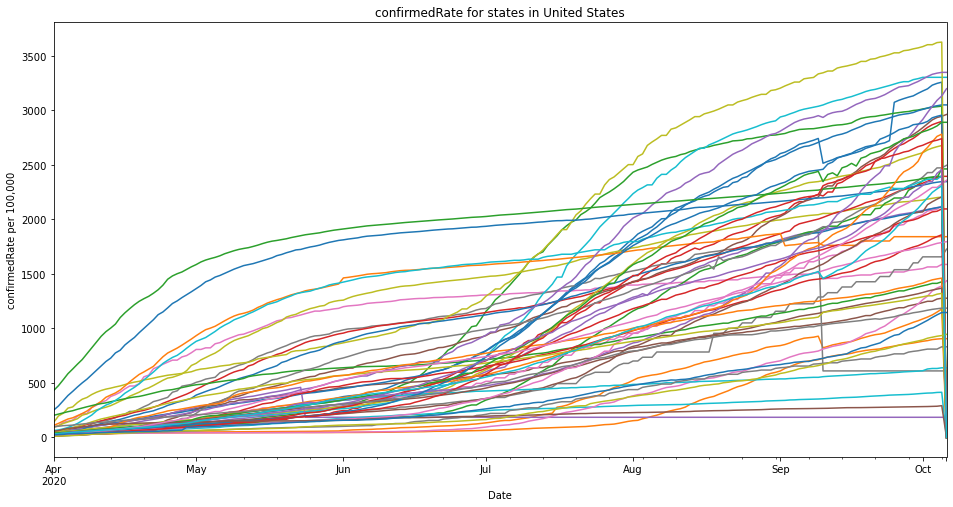

In [13]:
ax = df_date.plot(figsize=(16, 8), legend=False, title=f'{metric} for states in {country}');
ax.set_xlabel('Date');
ax.set_ylabel(f'{metric} per 100,000');

### Case counts by State

In [14]:
# dimensions for subplot layout
cols = 5
rows = math.ceil(df_date.shape[1]/cols)

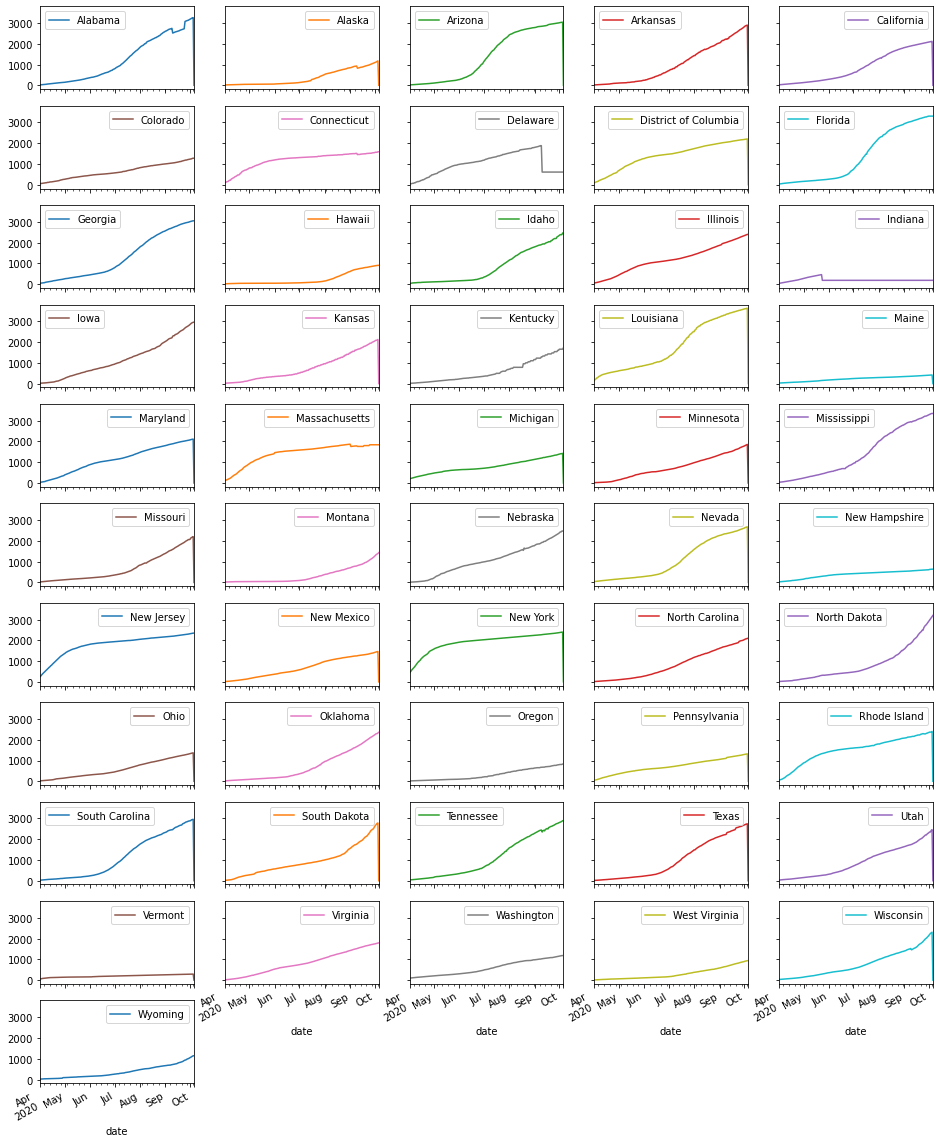

In [15]:
ax = df_date.plot(subplots=True, layout=(rows,cols), sharey=True, figsize=(16, 2*rows));